In [431]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from scipy.interpolate import interp1d
import torch.nn.functional as F
import contextlib
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
SEARCHSORTED_AVAILABLE = True
try:
    from torchsearchsorted import searchsorted
except ImportError:
    SEARCHSORTED_AVAILABLE = False

In [308]:
class Interp1d(torch.autograd.Function):
    def __call__(self, x, y, xnew, out=None):
        return self.forward(x, y, xnew, out)

    def forward(ctx, x, y, xnew, out=None):
        """
        Linear 1D interpolation on the GPU for Pytorch.
        This function returns interpolated values of a set of 1-D functions at
        the desired query points `xnew`.
        This function is working similarly to Matlab™ or scipy functions with
        the `linear` interpolation mode on, except that it parallelises over
        any number of desired interpolation problems.
        The code will run on GPU if all the tensors provided are on a cuda
        device.
        Parameters
        ----------
        x : (N, ) or (D, N) Pytorch Tensor
            A 1-D or 2-D tensor of real values.
        y : (N,) or (D, N) Pytorch Tensor
            A 1-D or 2-D tensor of real values. The length of `y` along its
            last dimension must be the same as that of `x`
        xnew : (P,) or (D, P) Pytorch Tensor
            A 1-D or 2-D tensor of real values. `xnew` can only be 1-D if
            _both_ `x` and `y` are 1-D. Otherwise, its length along the first
            dimension must be the same as that of whichever `x` and `y` is 2-D.
        out : Pytorch Tensor, same shape as `xnew`
            Tensor for the output. If None: allocated automatically.
        """
        # checking availability of the searchsorted pytorch module
        if not SEARCHSORTED_AVAILABLE:
            raise Exception(
                'The interp1d function depends on the '
                'torchsearchsorted module, which is not available.\n'
                'You must get it at ',
                'https://github.com/aliutkus/torchsearchsorted\n')

        # making the vectors at least 2D
        is_flat = {}
        require_grad = {}
        v = {}
        device = []
        eps = torch.finfo(y.dtype).eps
        for name, vec in {'x': x, 'y': y, 'xnew': xnew}.items():
            assert len(vec.shape) <= 2, 'interp1d: all inputs must be '\
                                        'at most 2-D.'
            if len(vec.shape) == 1:
                v[name] = vec[None, :]
            else:
                v[name] = vec
            is_flat[name] = v[name].shape[0] == 1
            require_grad[name] = vec.requires_grad
            device = list(set(device + [str(vec.device)]))
        assert len(device) == 1, 'All parameters must be on the same device.'
        device = device[0]

        # Checking for the dimensions
        assert (v['x'].shape[1] == v['y'].shape[1]
                and (
                     v['x'].shape[0] == v['y'].shape[0]
                     or v['x'].shape[0] == 1
                     or v['y'].shape[0] == 1
                    )
                ), ("x and y must have the same number of columns, and either "
                    "the same number of row or one of them having only one "
                    "row.")

        reshaped_xnew = False
        if ((v['x'].shape[0] == 1) and (v['y'].shape[0] == 1)
           and (v['xnew'].shape[0] > 1)):
            # if there is only one row for both x and y, there is no need to
            # loop over the rows of xnew because they will all have to face the
            # same interpolation problem. We should just stack them together to
            # call interp1d and put them back in place afterwards.
            original_xnew_shape = v['xnew'].shape
            v['xnew'] = v['xnew'].contiguous().view(1, -1)
            reshaped_xnew = True

        # identify the dimensions of output and check if the one provided is ok
        D = max(v['x'].shape[0], v['xnew'].shape[0])
        shape_ynew = (D, v['xnew'].shape[-1])
        if out is not None:
            if out.numel() != shape_ynew[0]*shape_ynew[1]:
                # The output provided is of incorrect shape.
                # Going for a new one
                out = None
            else:
                ynew = out.reshape(shape_ynew)
        if out is None:
            ynew = torch.zeros(*shape_ynew, device=device)

        # moving everything to the desired device in case it was not there
        # already (not handling the case things do not fit entirely, user will
        # do it if required.)
        for name in v:
            v[name] = v[name].to(device)

        # calling searchsorted on the x values.
        ind = ynew.long()
        searchsorted(v['x'].contiguous(), v['xnew'].contiguous(), ind)

        # the `-1` is because searchsorted looks for the index where the values
        # must be inserted to preserve order. And we want the index of the
        # preceeding value.
        ind -= 1
        # we clamp the index, because the number of intervals is x.shape-1,
        # and the left neighbour should hence be at most number of intervals
        # -1, i.e. number of columns in x -2
        ind = torch.clamp(ind, 0, v['x'].shape[1] - 1 - 1)

        # helper function to select stuff according to the found indices.
        def sel(name):
            if is_flat[name]:
                return v[name].contiguous().view(-1)[ind]
            return torch.gather(v[name], 1, ind)

        # activating gradient storing for everything now
        enable_grad = False
        saved_inputs = []
        for name in ['x', 'y', 'xnew']:
            if require_grad[name]:
                enable_grad = True
                saved_inputs += [v[name]]
            else:
                saved_inputs += [None, ]
        # assuming x are sorted in the dimension 1, computing the slopes for
        # the segments
        is_flat['slopes'] = is_flat['x']
        # now we have found the indices of the neighbors, we start building the
        # output. Hence, we start also activating gradient tracking
        with torch.enable_grad() if enable_grad else contextlib.suppress():
            v['slopes'] = (
                    (v['y'][:, 1:]-v['y'][:, :-1])
                    /
                    (eps + (v['x'][:, 1:]-v['x'][:, :-1]))
                )

            # now build the linear interpolation
            ynew = sel('y') + sel('slopes')*(
                                    v['xnew'] - sel('x'))

            if reshaped_xnew:
                ynew = ynew.view(original_xnew_shape)

        ctx.save_for_backward(ynew, *saved_inputs)
        return ynew

    @staticmethod
    def backward(ctx, grad_out):
        inputs = ctx.saved_tensors[1:]
        gradients = torch.autograd.grad(
                        ctx.saved_tensors[0],
                        [i for i in inputs if i is not None],
                        grad_out, retain_graph=True)
        result = [None, ] * 5
        pos = 0
        for index in range(len(inputs)):
            if inputs[index] is not None:
                result[index] = gradients[pos]
                pos += 1
        return (*result,)

In [309]:
interpolator = Interp1d()

In [230]:
T = 1000
v = np.random.uniform(0, 1, T)
# v[0] = 0.0

In [209]:
norm_v = np.linalg.norm(v, ord=1)

In [210]:
gamma_dot = np.power((v/norm_v), 2)

In [211]:
gamma = (T-1)*np.cumsum(gamma_dot)
gamma = np.concatenate([[0], gamma])

In [212]:
gamma = gamma/np.max(gamma)

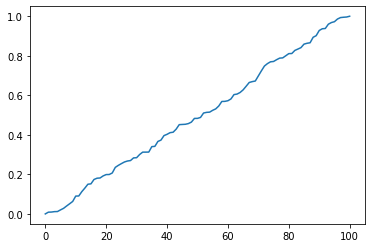

In [213]:
plt.plot(gamma)
# plt.ylim([-0.05, 1])
plt.show()

In [173]:
time_series1 = np.sin(np.linspace(0, 2*np.pi, T))
time_series2 = np.cos(np.linspace(0, 2*np.pi, T))

In [217]:
gamma = np.exp(np.linspace(0, 5, T))
gamma = gamma/np.max(gamma)
gamma[0] = 0.0

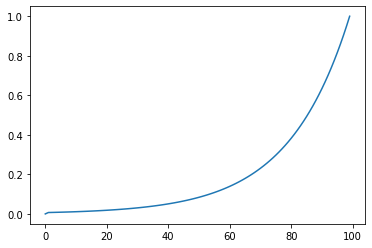

In [218]:
plt.plot(gamma)
plt.show()

In [ ]:
def interpolate(gamma, time_series):
    f = interp1d(time_series)
    return warped_series

In [349]:
# gamma = np.linspace(0, 1, T)
time_series = np.sin(np.linspace(0, 2*np.pi, T))
# gamma = np.sort(np.random.uniform(0, 1, T))
gamma = np.exp(np.linspace(0, 5, T))

gamma = gamma/np.max(gamma)
gamma[0] = 0.0
gamma[-1] = 1.0

In [350]:
f = interp1d(np.linspace(0, 1, T), time_series)

In [351]:
gamma = np.exp(np.linspace(0, 5, T))
gamma = gamma/np.max(gamma)
gamma[0] = 0.0
gamma[-1] = 1.0
f = interp1d(np.linspace(0, 1, T), time_series)
v_new = f(gamma)

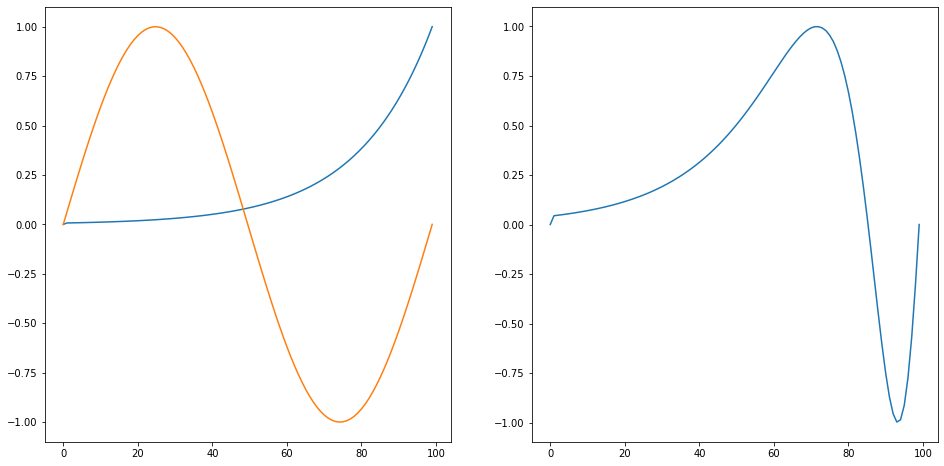

In [352]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(gamma)
ax[0].plot(time_series)
ax[1].plot(v_new)
plt.show()

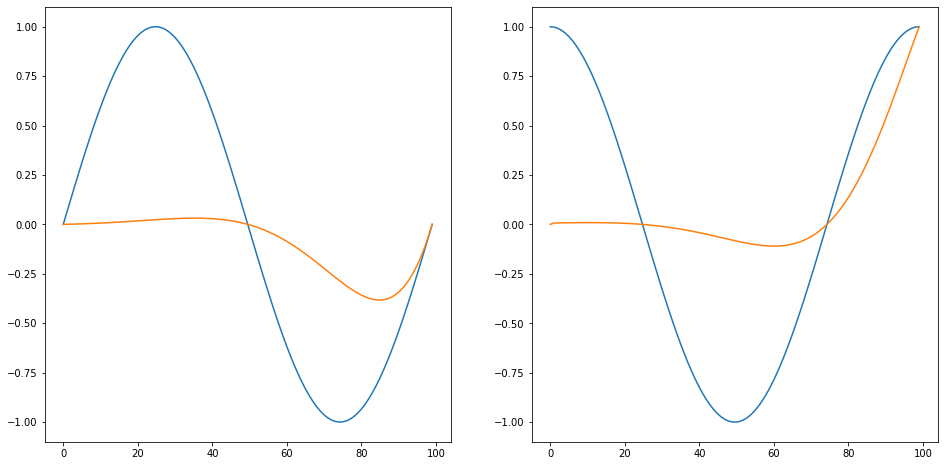

In [188]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].plot(time_series1)
ax[0].plot(time_series1*gamma)

ax[1].plot(time_series2)
ax[1].plot(time_series2*gamma)
plt.show()

In [146]:
norm = np.sqrt(v**2 + 1)
gamma_dot = (v/norm)**2
# np.cumsum(v/norm)*(T-1)

In [147]:
gamma = np.cumsum(gamma_dot)

In [148]:
gamma = np.concatenate([[0], gamma])
gamma = gamma*(T-1)

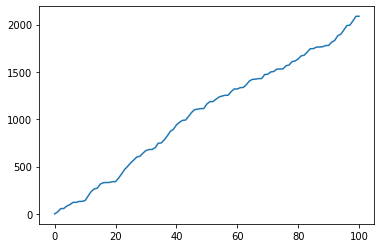

In [149]:
plt.plot(gamma)
# plt.ylim([-0.05, 1])
plt.show()

In [ ]:
  # Constraint satisfaction layers
  temp = tf.sqrt(tf.reduce_sum(tf.square(out1g), 1, keep_dims=True))
  batch_temp = tf.tile(temp, [1, seq_len-1])
  gamma_dot = tf.square(tf.div(out1g, batch_temp))
  gamma = tf.cumsum(gamma_dot, axis=1)
  zeros_vector = tf.zeros([batch_size,1])
  gamma = tf.concat([zeros_vector, gamma],1)
  gamma = gamma*(seq_len-1)

In [358]:
# Implementing all in torch
T = 100
time_series = torch.tensor(np.sin(np.linspace(0, 2*np.pi, T)))
# logits = torch.randn(T)
# gamma = torch.cumsum(torch.softmax(logits, 0), 0)
gamma = np.exp(np.linspace(0, 5, T))
gamma = gamma/np.max(gamma)
gamma[0] = 0.0
gamma[-1] = 1.0
gamma = torch.tensor(gamma, dtype=torch.float)

In [359]:
# Need interpolation in torch
Interpolator = Interp1d()

In [360]:
v_new = Interpolator(torch.linspace(0, 1, T), ts, gamma) #x, y, xnew

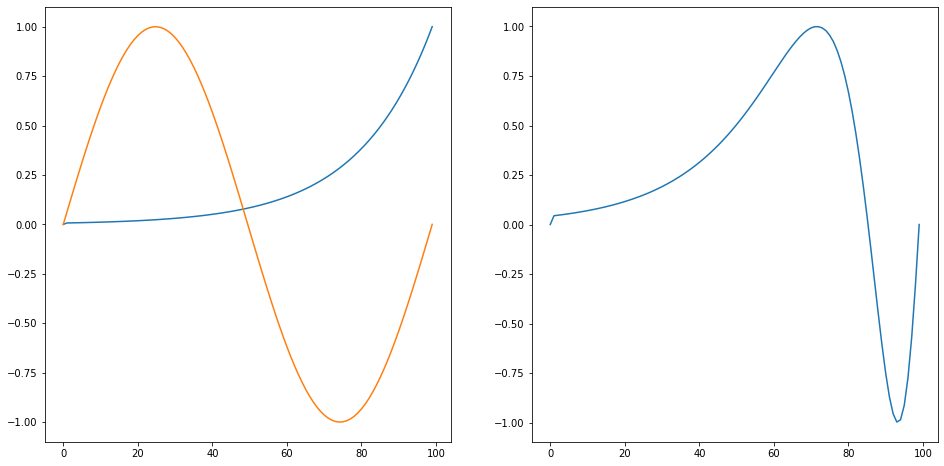

In [364]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(gamma)
ax[0].plot(time_series)
ax[1].plot(v_new.numpy().squeeze())
plt.show()

In [770]:
# Now let's get a machine learning example running... learn gamma!
class WarpClassifier(torch.nn.Module):
    def __init__(self, ninp, nclasses):
        # Expects time series of shape (N x T)
        super(WarpClassifier, self).__init__()
        
        self.fc = torch.nn.Linear(ninp, nclasses)
        self.w = torch.nn.Linear(ninp, ninp)
        self.Interpolator = Interp1d()
        
    def warp(self, x):
        self.gamma = torch.cumsum(torch.softmax(self.w(x), 1), 1)
        x = Interpolator(torch.linspace(0, 1, x.shape[1]), x, self.gamma)
        return x
        
    def forward(self, time_series):
        # Apply warping
        self.warped_time_series = self.warp(time_series)
        
        # Compute model's predictions
        logits = self.fc(self.warped_time_series)
#         self.warped_time_series = time_series
        return logits
    
    def computeLoss(self, y_hat, y):
        return F.cross_entropy(y_hat, y)

In [771]:
class CosSin(torch.utils.data.Dataset):
    def __init__(self, T=50, N=500):
        super(CosSin, self).__init__()
        self.N = N
        self.T = T
        self.data, self.labels = self.loadData()
        
    def __getitem__(self, ix):
        return self.data[ix], self.labels[ix]
    
    def __len__(self):
        return len(self.labels)
    
    def warp(self, time_series):
        gamma = np.exp(np.linspace(0, 5, self.T))
        gamma = gamma/np.max(gamma)
        gamma[0] = 0.0
        gamma[-1] = 1.0
        f = interp1d(np.linspace(0, 1, self.T), time_series)
        warped_time_series = f(gamma)
        return warped_time_series
    
    def loadData(self):
        data = []
        labels = []
#         values = np.zeros((self.N, self.T))
        values = np.random.normal(0, 0.005, (self.N, self.T))
        for i in range(self.N):
            if i <= int(self.N/2): # Dome
                time_series = np.sin(np.linspace(0, 2*np.pi, self.T))
                values[i, :] += self.warp(time_series)
                values[i, :] += time_series
                labels.append(0)
            else: # Table
                time_series = np.cos(np.linspace(0, 2*np.pi, self.T))
                values[i, :] += self.warp(self.warp(time_series))
#                 values[i, :] += self.warp(time_series)
                labels.append(1)
        self.train_ix = np.random.choice(np.arange(self.N), int(self.N*0.8), replace=False)
        self.test_ix = np.array(list(set(np.arange(self.N)) - set(self.train_ix)))
        return torch.tensor(values, dtype=torch.float), torch.tensor(labels, dtype=torch.long)

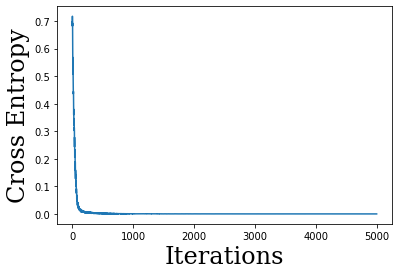

Test Accuracy: 100.0%


In [670]:
lr = 1e-03
nepoch = 100
bsz = 16
T = 50

D = CosSin(T=T, N=1000)
train_sampler = SubsetRandomSampler(D.train_ix)
train_loader = torch.utils.data.DataLoader(D, batch_size=bsz, sampler=train_sampler, drop_last=True)
test_sampler = SubsetRandomSampler(D.test_ix)
test_loader = torch.utils.data.DataLoader(D, batch_size=bsz, sampler=test_sampler, drop_last=True)

M = WarpClassifier(T, 2)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, M.parameters()), lr=lr, weight_decay=1e-05)

# Train
warped_time_series = []
warping_paths = []
train_labels = []
losses = []
for e in range(nepoch):
    for x, y in train_loader:
        train_labels.append(y)
        optimizer.zero_grad()
        logits = M(x)
        warped_time_series.append(M.warped_time_series.squeeze())
        warping_paths.append(M.gamma.squeeze())
        loss = M.computeLoss(logits, y)
        losses.append([loss.item()])
        loss.backward()
        optimizer.step()
warping_paths = torch.stack(warping_paths).squeeze()
warping_paths = warping_paths.reshape(-1, warping_paths.shape[-1])
warped_time_series = torch.stack(warped_time_series).reshape(-1, T)
train_labels = torch.stack(train_labels).squeeze()
train_labels = train_labels.reshape(-1)
        
# Test
predictions = []
test_labels = []
test_warps = []
warped_time_series = []
test_time_series = []
for x, y in test_loader:
    logits = M(x)
    test_warps.append(M.gamma.squeeze())
    [test_time_series.append(i) for i in x]
    test_labels.append(y)
    warped_time_series.append(M.warped_time_series.squeeze())
    y_hat = torch.softmax(logits, 1).argmax(1)
    predictions.append(y_hat)
test_labels = np.stack(test_labels).squeeze().reshape(-1)
predictions = np.stack(predictions).squeeze().reshape(-1)
test_warping_paths = torch.stack(test_warps).squeeze()
test_warping_paths = test_warping_paths.reshape(-1, test_warping_paths.shape[-1])
test_time_series = torch.stack(test_time_series).squeeze()
warped_time_series = torch.stack(warped_time_series).reshape(-1, T)

# Results
plt.plot(losses)
plt.xlabel("Iterations", fontfamily="serif", fontsize=24)
plt.ylabel("Cross Entropy", fontfamily="serif", fontsize=24)
plt.show()
print("Test Accuracy: {}%".format(100*np.mean(test_labels == predictions)))

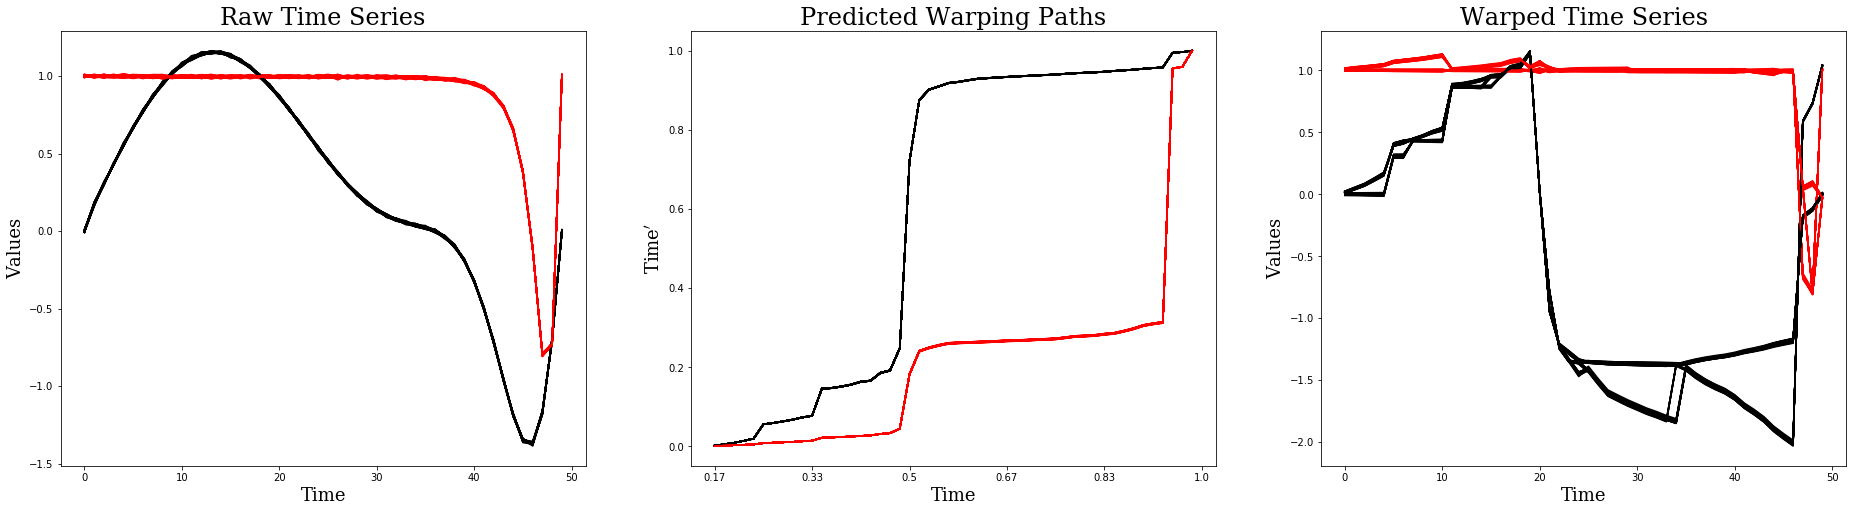

In [671]:
fig, ax = plt.subplots(1, 3, figsize=(32, 8))

colors = ["k", "r"]

for i in range(len(test_time_series)):
# for i in range(10):
    ax[0].plot(test_time_series[i].detach().numpy(), c=colors[int(test_labels[i])])
    ax[1].plot(test_warping_paths[i].detach().numpy(), c=colors[int(test_labels[i])])
    ax[2].plot(warped_time_series[i].detach().numpy(), c=colors[int(test_labels[i])])
    
ax[0].set_title("Raw Time Series", fontfamily="serif", fontsize=24)
ax[0].set_xlabel("Time", fontfamily="serif", fontsize=18)
ax[0].set_ylabel("Values", fontfamily="serif", fontsize=18)
ax[1].set_title("Predicted Warping Paths", fontfamily="serif", fontsize=24)
ax[1].set_xlabel("Time", fontfamily="serif", fontsize=18)
ax[1].set_xticklabels(np.round(np.linspace(0, 1, 7), 2))
ax[1].set_ylabel(r"Time$^\prime$", fontfamily="serif", fontsize=18)
ax[2].set_title("Warped Time Series", fontfamily="serif", fontsize=24)
ax[2].set_xlabel("Time", fontfamily="serif", fontsize=18)
ax[2].set_ylabel("Values", fontfamily="serif", fontsize=18)
plt.show()

In [763]:
# Let's try some real data!
class UCR(torch.utils.data.Dataset):
    def __init__(self, T=50, N=500, dataset="ECGFiveDays"):
        super(UCR, self).__init__()
        self.dataset = dataset
        self.data, self.labels = self.loadData()
        self.nclasses = len(np.unique(self.labels))
        
    def __getitem__(self, ix):
        return self.data[ix], self.labels[ix]
    
    def __len__(self):
        return len(self.labels)
    
    def loadData(self):
        train = np.loadtxt("/home/tom/Documents/data/UCR_TS_Archive_2015/{}/{}_TRAIN".format(self.dataset, self.dataset), delimiter=",")
        test = np.loadtxt("/home/tom/Documents/data/UCR_TS_Archive_2015/{}/{}_TEST".format(self.dataset, self.dataset), delimiter=",")
        data = np.concatenate((train, test))
        labels = data[:, 0] - 1 # ECGFiveDays
#         labels = np.clip(data[:, 0], 0, 1)
        values = data[:, 1:]
        self.N = len(data)
        self.T = values.shape[1]
        self.train_ix = np.random.choice(np.arange(self.N), int(self.N*0.8), replace=False)
        self.test_ix = np.array(list(set(np.arange(self.N)) - set(self.train_ix)))
        return torch.tensor(values, dtype=torch.float), torch.tensor(labels, dtype=torch.long)

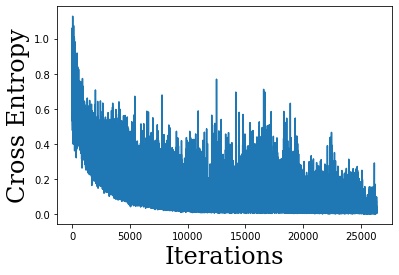

Test Accuracy: 98.86363636363636%


In [782]:
lr = 1e-05
nepoch = 300
bsz = 8

dataset = "ECG200"
D = UCR(dataset)
T = D.T
nclasses = D.nclasses
train_sampler = SubsetRandomSampler(D.train_ix)
train_loader = torch.utils.data.DataLoader(D, batch_size=bsz, sampler=train_sampler, drop_last=True)
test_sampler = SubsetRandomSampler(D.test_ix)
test_loader = torch.utils.data.DataLoader(D, batch_size=bsz, sampler=test_sampler, drop_last=True)

M = WarpClassifier(T, nclasses)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, M.parameters()), lr=lr, weight_decay=1e-05)

# Train
warped_time_series = []
warping_paths = []
train_labels = []
losses = []
for e in range(nepoch):
    for x, y in train_loader:
        train_labels.append(y)
        optimizer.zero_grad()
        logits = M(x)
        warped_time_series.append(M.warped_time_series.squeeze())
        warping_paths.append(M.gamma.squeeze())
#         warping_paths.append(M.warped_time_series.squeeze())
        loss = M.computeLoss(logits, y)
        losses.append([loss.item()])
        loss.backward()
        optimizer.step()
warping_paths = torch.stack(warping_paths).squeeze()
warping_paths = warping_paths.reshape(-1, warping_paths.shape[-1])
warped_time_series = torch.stack(warped_time_series).reshape(-1, T)
train_labels = torch.stack(train_labels).squeeze()
train_labels = train_labels.reshape(-1)
        
# Test
predictions = []
test_labels = []
test_warps = []
warped_time_series = []
test_time_series = []
for x, y in test_loader:
    logits = M(x)
    test_warps.append(M.gamma.squeeze())
#     test_warps.append(M.warped_time_series.squeeze())
    [test_time_series.append(i) for i in x]
    test_labels.append(y)
    warped_time_series.append(M.warped_time_series.squeeze())
    y_hat = torch.softmax(logits, 1).argmax(1)
    predictions.append(y_hat)
test_labels = np.stack(test_labels).squeeze().reshape(-1)
predictions = np.stack(predictions).squeeze().reshape(-1)
test_warping_paths = torch.stack(test_warps).squeeze()
test_warping_paths = test_warping_paths.reshape(-1, test_warping_paths.shape[-1])
test_time_series = torch.stack(test_time_series).squeeze()
warped_time_series = torch.stack(warped_time_series).reshape(-1, T)

# Results
plt.plot(losses)
plt.xlabel("Iterations", fontfamily="serif", fontsize=24)
plt.ylabel("Cross Entropy", fontfamily="serif", fontsize=24)
plt.show()
print("Test Accuracy: {}%".format(100*np.mean(test_labels == predictions)))

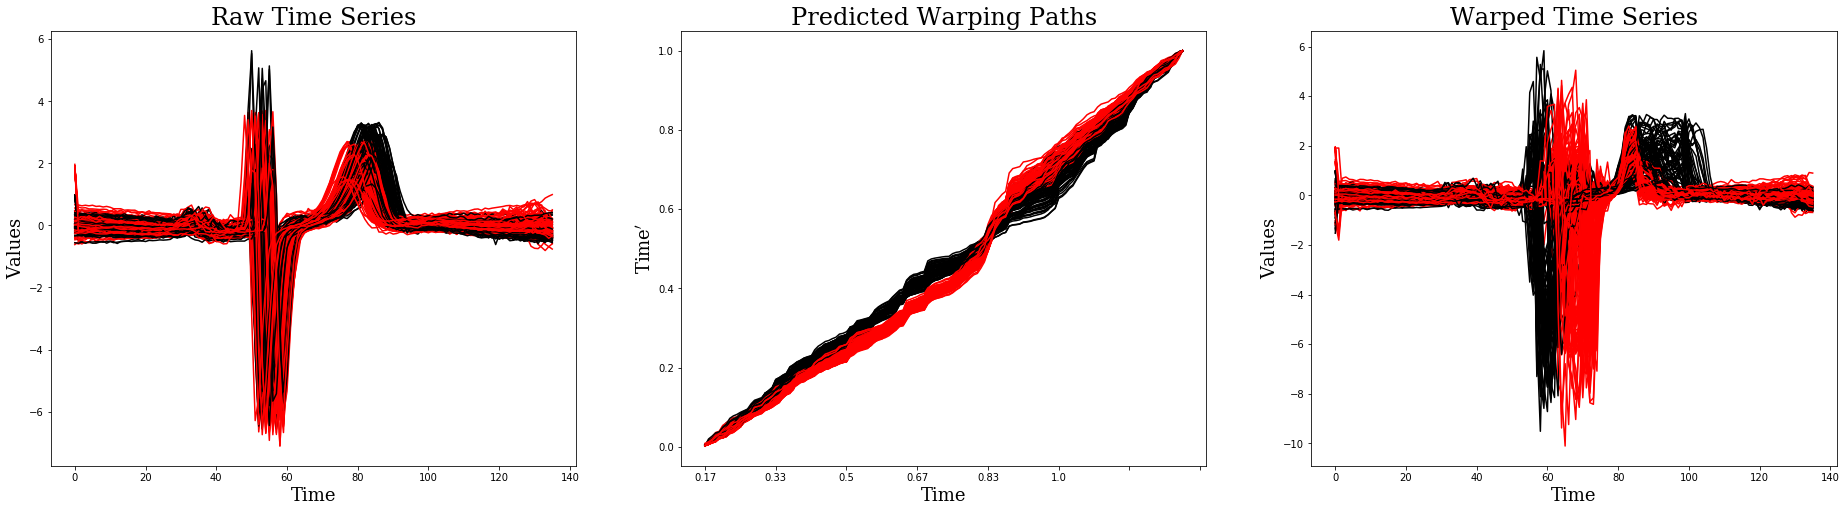

In [783]:
fig, ax = plt.subplots(1, 3, figsize=(32, 8))

colors = ["k", "r"]

for i in range(len(test_time_series)):
# for i in range(10):
    ax[0].plot(test_time_series[i].detach().numpy(), c=colors[int(test_labels[i])])
    ax[1].plot(test_warping_paths[i].detach().numpy(), c=colors[int(test_labels[i])])
    ax[2].plot(warped_time_series[i].detach().numpy(), c=colors[int(test_labels[i])])
    
ax[0].set_title("Raw Time Series", fontfamily="serif", fontsize=24)
ax[0].set_xlabel("Time", fontfamily="serif", fontsize=18)
ax[0].set_ylabel("Values", fontfamily="serif", fontsize=18)
ax[1].set_title("Predicted Warping Paths", fontfamily="serif", fontsize=24)
ax[1].set_xlabel("Time", fontfamily="serif", fontsize=18)
ax[1].set_xticklabels(np.round(np.linspace(0, 1, 7), 2))
ax[1].set_ylabel(r"Time$^\prime$", fontfamily="serif", fontsize=18)
ax[2].set_title("Warped Time Series", fontfamily="serif", fontsize=24)
ax[2].set_xlabel("Time", fontfamily="serif", fontsize=18)
ax[2].set_ylabel("Values", fontfamily="serif", fontsize=18)
plt.show()

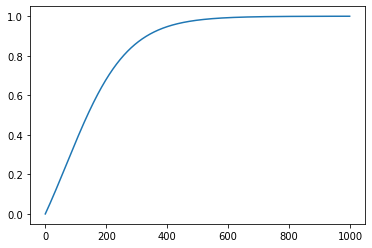

In [820]:
gamma = 1/(0.5+np.exp(-10*np.linspace(0.000001, 1, T)))
gamma = (gamma-np.min(gamma))/(np.max(gamma)-np.min(gamma))
plt.plot(gamma)
plt.show()

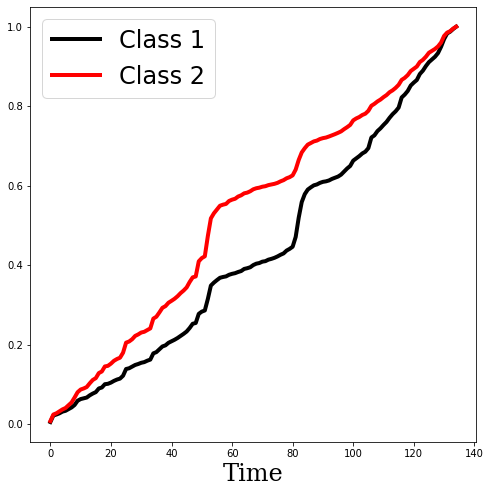

In [780]:
# Compute Class-wise averages
fig, ax = plt.subplots(figsize=(8, 8))

c1_mean = test_warping_paths[np.where(test_labels == 0.), 1:].squeeze().mean(0).detach().numpy()
c2_mean = test_warping_paths[np.where(test_labels == 1.), 1:].squeeze().mean(0).detach().numpy()

ax.plot(c1_mean, c="k", label="Class 1", lw=4)
ax.plot(c2_mean, c="r", label="Class 2", lw=4)
ax.legend(loc="upper left", fontsize=24)
ax.set_xlabel("Time", fontfamily="serif", fontsize=24)
plt.show()

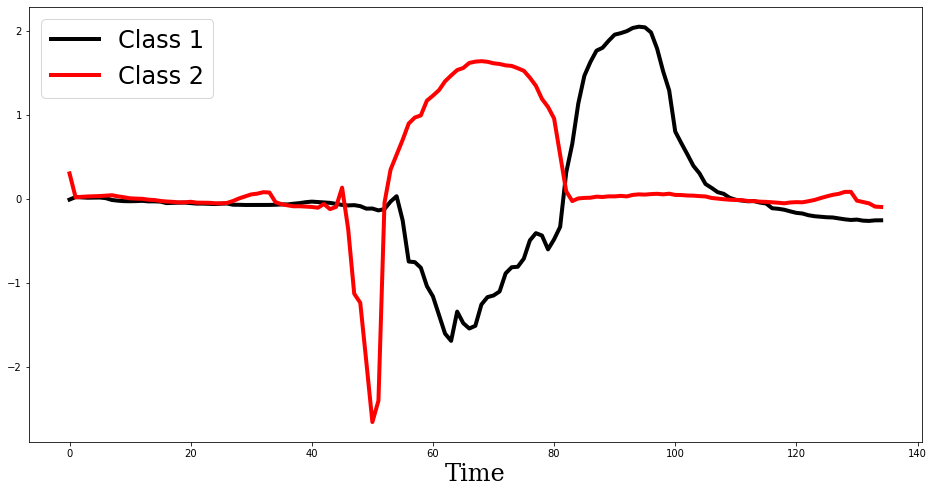

In [781]:
# Compute Class-wise averages
fig, ax = plt.subplots(figsize=(8, 8))

c1_mean = test_warping_paths[np.where(test_labels == 0.), 1:].squeeze().mean(0).detach().numpy()
c2_mean = test_warping_paths[np.where(test_labels == 1.), 1:].squeeze().mean(0).detach().numpy()

ax.plot(c1_mean, c="k", label="Class 1", lw=4)
ax.plot(c2_mean, c="r", label="Class 2", lw=4)
ax.legend(loc="upper left", fontsize=24)
ax.set_xlabel("Time", fontfamily="serif", fontsize=24)
plt.show()

# Compute Class-wise averages
fig, ax = plt.subplots(figsize=(16, 8))

c1_mean = warped_time_series[np.where(test_labels == 0.), 1:].squeeze().mean(0).detach().numpy()
c2_mean = warped_time_series[np.where(test_labels == 1.), 1:].squeeze().mean(0).detach().numpy()

ax.plot(c1_mean, c="k", label="Class 1", lw=4)
ax.plot(c2_mean, c="r", label="Class 2", lw=4)
ax.legend(loc="upper left", fontsize=24)
ax.set_xlabel("Time", fontfamily="serif", fontsize=24)
plt.show()

In [838]:
# Now what if classes are warped differently?
class DiffWarps(torch.utils.data.Dataset):
    def __init__(self, T=50, N=500):
        super(DiffWarps, self).__init__()
        self.N = N
        self.T = T
        self.data, self.labels = self.loadData()
        
    def __getitem__(self, ix):
        return self.data[ix], self.labels[ix]
    
    def __len__(self):
        return len(self.labels)
    
    def logisticWarp(self):
        gamma = 1/(0.5+np.exp(-10*np.linspace(0.000001, 1, self.T)))
        gamma = (gamma-np.min(gamma))/(np.max(gamma)-np.min(gamma))
        return gamma
    
    def exponentialWarp(self):
        gamma = np.exp(np.linspace(0, 5, self.T))
        gamma = gamma/np.max(gamma) 
        return gamma
    
    def identityWarp(self):
        return np.linspace(0, 1, self.T)
    
    def warp(self, time_series, class1=True):
        if class1:
            # Sin
#             gamma = self.exponentialWarp() 
            gamma = self.logisticWarp()
        else:
            # Cos
#             gamma = self.logisticWarp()
            gamma = self.identityWarp()
        gamma[0] = 0.0
        gamma[-1] = 1.0
        f = interp1d(np.linspace(0, 1, self.T), time_series)
        warped_time_series = f(gamma)
        return warped_time_series
    
    def loadData(self):
        data = []
        labels = []
#         values = np.zeros((self.N, self.T))
        values = np.random.normal(0, 0.3, (self.N, self.T))
        for i in range(self.N):
            if i <= int(self.N/2): # Dome
                time_series = np.cos(np.linspace(0, 2*np.pi, self.T))
#                 time_series = np.sin(np.linspace(0, 2*np.pi, self.T))
                values[i, :] += self.warp(time_series, class1=True)
#                 values[i, :] += time_series
                labels.append(0)
            else: # Table
                time_series = np.cos(np.linspace(0, 2*np.pi, self.T))
                values[i, :] += self.warp(time_series, class1=False)
#                 values[i, :] += self.warp(time_series)
                labels.append(1)
        self.train_ix = np.random.choice(np.arange(self.N), int(self.N*0.8), replace=False)
        self.test_ix = np.array(list(set(np.arange(self.N)) - set(self.train_ix)))
        return torch.tensor(values, dtype=torch.float), torch.tensor(labels, dtype=torch.long)

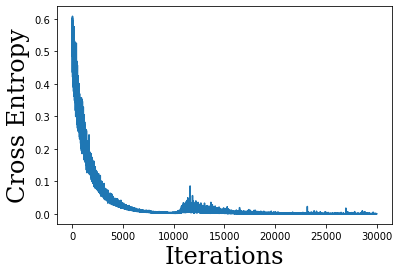

Test Accuracy: 100.0%


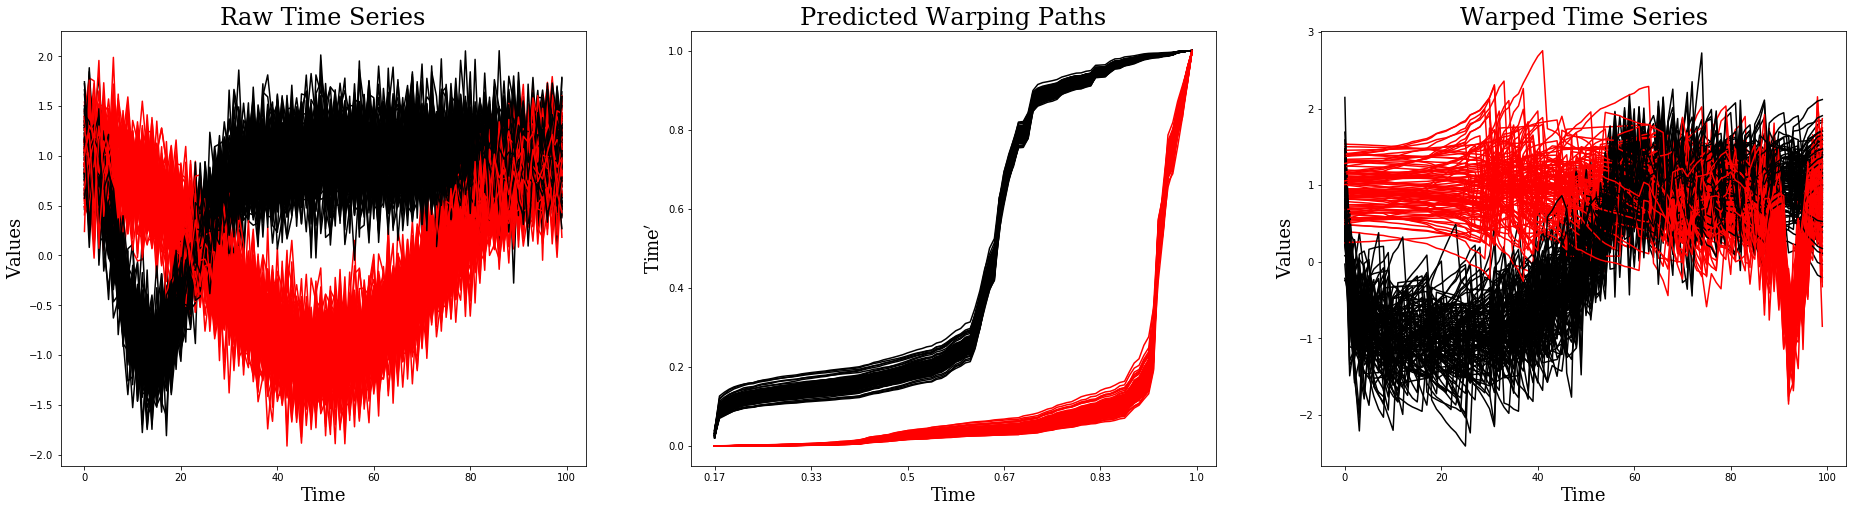

In [839]:
lr = 1e-05
nepoch = 600
bsz = 16

T = 100
N = 1000
D = DiffWarps(T, N)
nclasses = 2
train_sampler = SubsetRandomSampler(D.train_ix)
train_loader = torch.utils.data.DataLoader(D, batch_size=bsz, sampler=train_sampler, drop_last=True)
test_sampler = SubsetRandomSampler(D.test_ix)
test_loader = torch.utils.data.DataLoader(D, batch_size=bsz, sampler=test_sampler, drop_last=True)

M = WarpClassifier(T, nclasses)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, M.parameters()), lr=lr, weight_decay=1e-05)

# Train
warped_time_series = []
warping_paths = []
train_labels = []
losses = []
for e in range(nepoch):
    for x, y in train_loader:
        train_labels.append(y)
        optimizer.zero_grad()
        logits = M(x)
        warped_time_series.append(M.warped_time_series.squeeze())
        warping_paths.append(M.gamma.squeeze())
        loss = M.computeLoss(logits, y)
        losses.append([loss.item()])
        loss.backward()
        optimizer.step()
warping_paths = torch.stack(warping_paths).squeeze()
warping_paths = warping_paths.reshape(-1, warping_paths.shape[-1])
warped_time_series = torch.stack(warped_time_series).reshape(-1, T)
train_labels = torch.stack(train_labels).squeeze()
train_labels = train_labels.reshape(-1)
        
# Test
predictions = []
test_labels = []
test_warps = []
warped_time_series = []
test_time_series = []
for x, y in test_loader:
    logits = M(x)
    test_warps.append(M.gamma.squeeze())
    [test_time_series.append(i) for i in x]
    test_labels.append(y)
    warped_time_series.append(M.warped_time_series.squeeze())
    y_hat = torch.softmax(logits, 1).argmax(1)
    predictions.append(y_hat)
test_labels = np.stack(test_labels).squeeze().reshape(-1)
predictions = np.stack(predictions).squeeze().reshape(-1)
test_warping_paths = torch.stack(test_warps).squeeze()
test_warping_paths = test_warping_paths.reshape(-1, test_warping_paths.shape[-1])
test_time_series = torch.stack(test_time_series).squeeze()
warped_time_series = torch.stack(warped_time_series).reshape(-1, T)

# Results
plt.plot(losses)
plt.xlabel("Iterations", fontfamily="serif", fontsize=24)
plt.ylabel("Cross Entropy", fontfamily="serif", fontsize=24)
plt.show()
print("Test Accuracy: {}%".format(100*np.mean(test_labels == predictions)))

fig, ax = plt.subplots(1, 3, figsize=(32, 8))

colors = ["k", "r"]

for i in range(len(test_time_series)):
# for i in range(10):
    ax[0].plot(test_time_series[i].detach().numpy(), c=colors[int(test_labels[i])])
    ax[1].plot(test_warping_paths[i].detach().numpy(), c=colors[int(test_labels[i])])
    ax[2].plot(warped_time_series[i].detach().numpy(), c=colors[int(test_labels[i])])
    
ax[0].set_title("Raw Time Series", fontfamily="serif", fontsize=24)
ax[0].set_xlabel("Time", fontfamily="serif", fontsize=18)
ax[0].set_ylabel("Values", fontfamily="serif", fontsize=18)
ax[1].set_title("Predicted Warping Paths", fontfamily="serif", fontsize=24)
ax[1].set_xlabel("Time", fontfamily="serif", fontsize=18)
ax[1].set_xticklabels(np.round(np.linspace(0, 1, 7), 2))
ax[1].set_ylabel(r"Time$^\prime$", fontfamily="serif", fontsize=18)
ax[2].set_title("Warped Time Series", fontfamily="serif", fontsize=24)
ax[2].set_xlabel("Time", fontfamily="serif", fontsize=18)
ax[2].set_ylabel("Values", 
fontfamily="serif", fontsize=18)
plt.show()

In [843]:
# Now what if classes are warped differently?
class RandomWarps(torch.utils.data.Dataset):
    def __init__(self, T=50, N=500):
        super(RandomWarps, self).__init__()
        self.N = N
        self.T = T
        self.data, self.labels = self.loadData()
        
    def __getitem__(self, ix):
        return self.data[ix], self.labels[ix]
    
    def __len__(self):
        return len(self.labels)
    
    def logisticWarp(self):
        gamma = 1/(0.5+np.exp(-10*np.linspace(0.000001, 1, self.T)))
        gamma = (gamma-np.min(gamma))/(np.max(gamma)-np.min(gamma))
        return gamma
    
    def exponentialWarp(self):
        gamma = np.exp(np.linspace(0, 5, self.T))
        gamma = gamma/np.max(gamma) 
        return gamma
    
    def identityWarp(self):
        return np.linspace(0, 1, self.T)
    
    def randomWarp(self):
        return np.sort(np.random.uniform(0, 1, self.T))
    
    def warp(self, time_series, class1=True):
        if class1:
            # Sin
            gamma = self.randomWarp()
        else:
            # Cos
            gamma = self.randomWarp()
        gamma[0] = 0.0
        gamma[-1] = 1.0
        f = interp1d(np.linspace(0, 1, self.T), time_series)
        warped_time_series = f(gamma)
        return warped_time_series
    
    def loadData(self):
        data = []
        labels = []
#         values = np.zeros((self.N, self.T))
        values = np.random.normal(0, 0.3, (self.N, self.T))
        for i in range(self.N):
            if i <= int(self.N/2): # Dome
                time_series = np.sin(np.linspace(0, 2*np.pi, self.T))
                values[i, :] += self.warp(time_series, class1=True)
                labels.append(0)
            else: # Table
                time_series = np.cos(np.linspace(0, 2*np.pi, self.T))
                values[i, :] += self.warp(time_series, class1=False)
                labels.append(1)
        self.train_ix = np.random.choice(np.arange(self.N), int(self.N*0.8), replace=False)
        self.test_ix = np.array(list(set(np.arange(self.N)) - set(self.train_ix)))
        return torch.tensor(values, dtype=torch.float), torch.tensor(labels, dtype=torch.long)

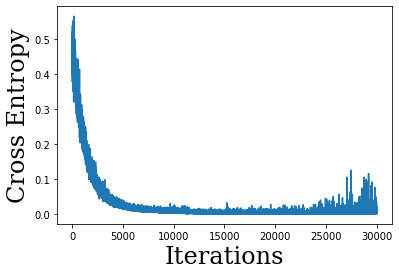

Test Accuracy: 100.0%


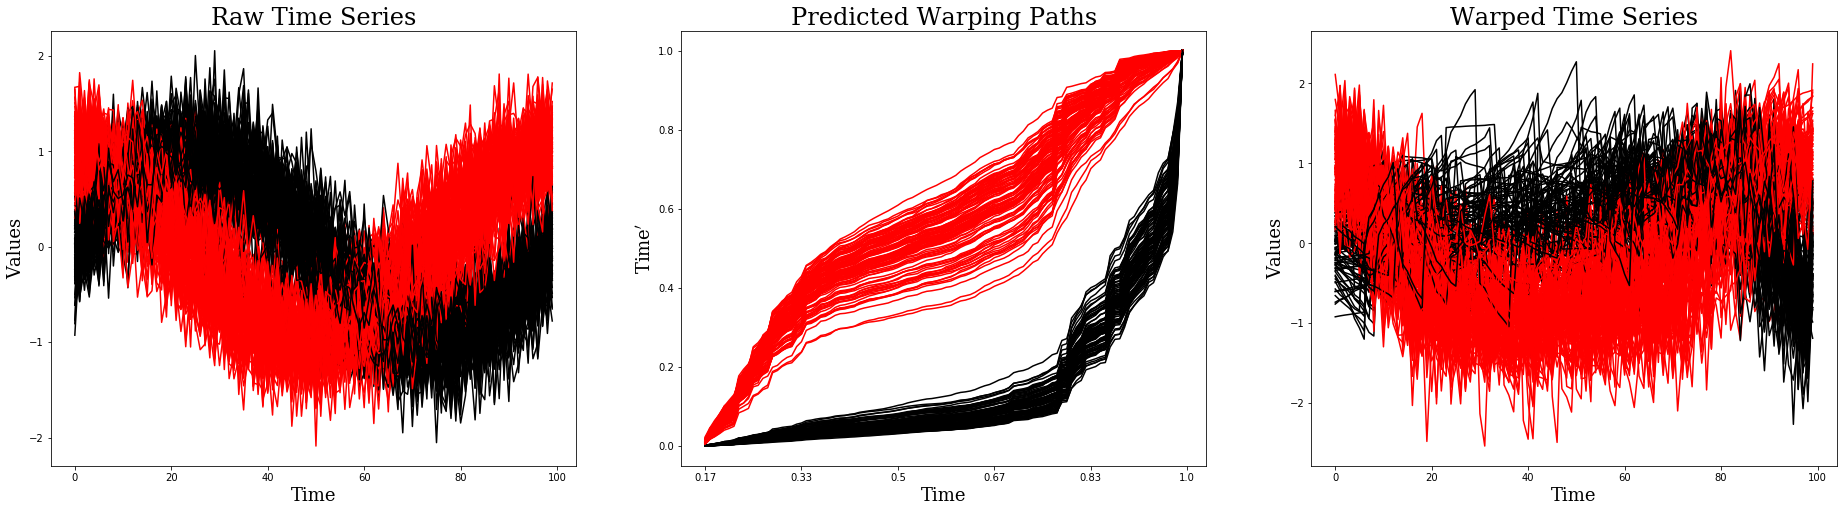

In [844]:
lr = 1e-05
nepoch = 600
bsz = 16

T = 100
N = 1000
D = RandomWarps(T, N)
nclasses = 2
train_sampler = SubsetRandomSampler(D.train_ix)
train_loader = torch.utils.data.DataLoader(D, batch_size=bsz, sampler=train_sampler, drop_last=True)
test_sampler = SubsetRandomSampler(D.test_ix)
test_loader = torch.utils.data.DataLoader(D, batch_size=bsz, sampler=test_sampler, drop_last=True)

M = WarpClassifier(T, nclasses)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, M.parameters()), lr=lr, weight_decay=1e-05)

# Train
warped_time_series = []
warping_paths = []
train_labels = []
losses = []
for e in range(nepoch):
    for x, y in train_loader:
        train_labels.append(y)
        optimizer.zero_grad()
        logits = M(x)
        warped_time_series.append(M.warped_time_series.squeeze())
        warping_paths.append(M.gamma.squeeze())
        loss = M.computeLoss(logits, y)
        losses.append([loss.item()])
        loss.backward()
        optimizer.step()
warping_paths = torch.stack(warping_paths).squeeze()
warping_paths = warping_paths.reshape(-1, warping_paths.shape[-1])
warped_time_series = torch.stack(warped_time_series).reshape(-1, T)
train_labels = torch.stack(train_labels).squeeze()
train_labels = train_labels.reshape(-1)
        
# Test
predictions = []
test_labels = []
test_warps = []
warped_time_series = []
test_time_series = []
for x, y in test_loader:
    logits = M(x)
    test_warps.append(M.gamma.squeeze())
    [test_time_series.append(i) for i in x]
    test_labels.append(y)
    warped_time_series.append(M.warped_time_series.squeeze())
    y_hat = torch.softmax(logits, 1).argmax(1)
    predictions.append(y_hat)
test_labels = np.stack(test_labels).squeeze().reshape(-1)
predictions = np.stack(predictions).squeeze().reshape(-1)
test_warping_paths = torch.stack(test_warps).squeeze()
test_warping_paths = test_warping_paths.reshape(-1, test_warping_paths.shape[-1])
test_time_series = torch.stack(test_time_series).squeeze()
warped_time_series = torch.stack(warped_time_series).reshape(-1, T)

# Results
plt.plot(losses)
plt.xlabel("Iterations", fontfamily="serif", fontsize=24)
plt.ylabel("Cross Entropy", fontfamily="serif", fontsize=24)
plt.show()
print("Test Accuracy: {}%".format(100*np.mean(test_labels == predictions)))

fig, ax = plt.subplots(1, 3, figsize=(32, 8))

colors = ["k", "r"]

for i in range(len(test_time_series)):
# for i in range(10):
    ax[0].plot(test_time_series[i].detach().numpy(), c=colors[int(test_labels[i])])
    ax[1].plot(test_warping_paths[i].detach().numpy(), c=colors[int(test_labels[i])])
    ax[2].plot(warped_time_series[i].detach().numpy(), c=colors[int(test_labels[i])])
    
ax[0].set_title("Raw Time Series", fontfamily="serif", fontsize=24)
ax[0].set_xlabel("Time", fontfamily="serif", fontsize=18)
ax[0].set_ylabel("Values", fontfamily="serif", fontsize=18)
ax[1].set_title("Predicted Warping Paths", fontfamily="serif", fontsize=24)
ax[1].set_xlabel("Time", fontfamily="serif", fontsize=18)
ax[1].set_xticklabels(np.round(np.linspace(0, 1, 7), 2))
ax[1].set_ylabel(r"Time$^\prime$", fontfamily="serif", fontsize=18)
ax[2].set_title("Warped Time Series", fontfamily="serif", fontsize=24)
ax[2].set_xlabel("Time", fontfamily="serif", fontsize=18)
ax[2].set_ylabel("Values", 
fontfamily="serif", fontsize=18)
plt.show()

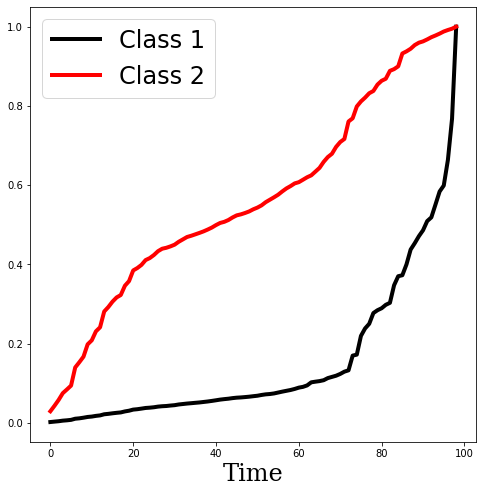

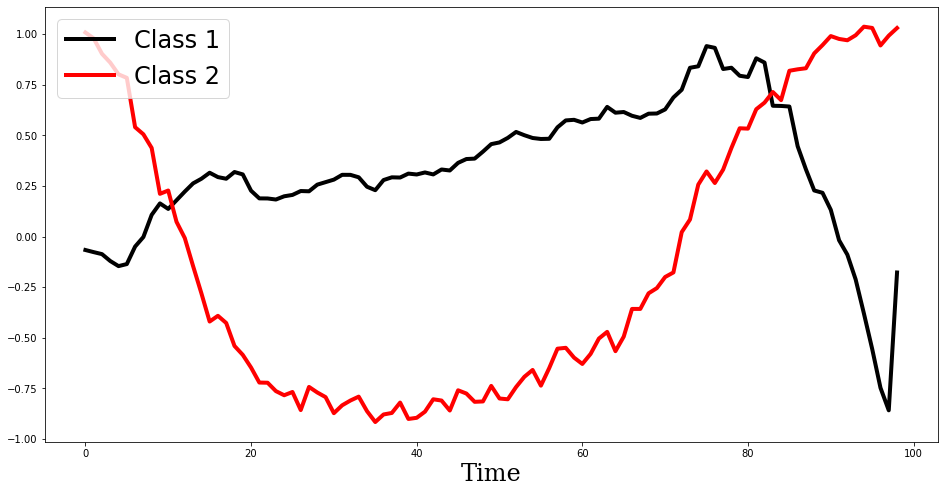

In [845]:
# Compute Class-wise averages
fig, ax = plt.subplots(figsize=(8, 8))

c1_mean = test_warping_paths[np.where(test_labels == 0.), 1:].squeeze().mean(0).detach().numpy()
c2_mean = test_warping_paths[np.where(test_labels == 1.), 1:].squeeze().mean(0).detach().numpy()

ax.plot(c1_mean, c="k", label="Class 1", lw=4)
ax.plot(c2_mean, c="r", label="Class 2", lw=4)
ax.legend(loc="upper left", fontsize=24)
ax.set_xlabel("Time", fontfamily="serif", fontsize=24)
plt.show()

# Compute Class-wise averages
fig, ax = plt.subplots(figsize=(16, 8))

c1_mean = warped_time_series[np.where(test_labels == 0.), 1:].squeeze().mean(0).detach().numpy()
c2_mean = warped_time_series[np.where(test_labels == 1.), 1:].squeeze().mean(0).detach().numpy()

ax.plot(c1_mean, c="k", label="Class 1", lw=4)
ax.plot(c2_mean, c="r", label="Class 2", lw=4)
ax.legend(loc="upper left", fontsize=24)
ax.set_xlabel("Time", fontfamily="serif", fontsize=24)
plt.show()